# Circonus for Data Science

A frequent request we were hearing from many customers is:

> How can I analyze my data with Python?

The python Data Science toolchain (Jupyer/NumPy/pandas) offers a wide spectrum of advanced data anlaytics capabilities.
Hence seamless integration with this environment is important for our customers that want to make use of those tools.

Circonus has for a long time provided [python bindings](https://github.com/circonus-labs/python-circonusapi) for it's API.
With this bindings you can configure the account, create graphs and dashboards, etc.
However, fetching data and getting it into the right format involves multiple steps and was not easy to get right.

We are pleased to announce that this has changed now.
We have just added a new capabilities to our python bindings, that allow you to fetch and analyze data more effectively.
Here is how to use it.

## Quick Tour

In [1]:
### SKIP THIS CELL ###

%matplotlib inline

import json
import os
from datetime import datetime
import pandas as pd

with open(os.path.expanduser("~/work/.circonusrc.json"),"r") as fh:
    config = json.load(fh)
api_token = config['demo']

### Connecting to the API

You need an API token to connect to the API.
You can create one using the UI under Integrations > API Tokens.
In the following we assume the vairable api_token holds a valid API token for your account.

In [2]:
from circonusapi import circonusdata
circ = circonusdata.CirconusData(api_token)

### Searching for Metrics

The first thing we can do is search for some metrics:

In [3]:
M = circ.search('(metric:duration)', limit=10)

The returned object extends the list class, and can be manipulated like any list object:

In [4]:
print(M[0])
print(len(M))

CirconusMetric{check_id=195902,name=duration}
10


Printing the list, gives a table representation of the fetched metrics

In [5]:
print(M)

check_id   type       metric_name
--------------------------------------------------
195902     numeric    duration                                          
218003     numeric    duration                                          
154743     numeric    duration                                          
217833     numeric    duration                                          
217834     numeric    duration                                          
218002     numeric    duration                                          
222857     numeric    duration                                          
222854     numeric    duration                                          
222862     numeric    duration                                          
222860     numeric    duration                                          


Metric lists provide a .fetch() method that can be used to fetch data.
Fetches are performed serially, one metric at a time, so the retrival can take some time.
We will later see how to parallelize fetches with CAQL.

In [6]:
R = M.fetch(
    start=datetime(2018,1,1), # start at Midnight UTC 2018-01-01
    period=60,                # return 60 second (=1min) aggregates
    count=180,                # return 180 samples
    kind="value"              # return (mean-)value aggregate
)

The resulting object is a dict that maps metrics names to the fetched data
This is designed in such a way that it can be directly passed to a pandas DataFrame constructor.

In [7]:
import pandas as pd
df = pd.DataFrame(R)

# [OPTIONAL] Make the DataFrame aware of the time column
df['time']=pd.to_datetime(df['time'],unit='s')
df.set_index('time', inplace=True)

df.head()

,154743/duration,195902/duration,217833/duration,217834/duration,218002/duration,218003/duration,222854/duration,222857/duration,222860/duration,222862/duration
time,,,,,,,,,,
2018-01-01 00:00:00,1,4,1,1,1,1,12,11,12,1
2018-01-01 00:01:00,1,2,1,1,2,1,11,12,12,1
2018-01-01 00:02:00,1,2,1,1,1,1,12,12,11,1
2018-01-01 00:03:00,1,2,1,1,1,1,12,11,12,1
2018-01-01 00:04:00,1,2,1,1,1,1,12,11,11,1


### Data Analysis with pandas

pandas makes common data analysis methods very easy to perform.
We start with computing some summary statistics

In [8]:
df.describe()

,154743/duration,195902/duration,217833/duration,217834/duration,218002/duration,218003/duration,222854/duration,222857/duration,222860/duration,222862/duration
count,180.000000,180.000000,180.0,180.000000,180.000000,180.000000,180.000000,180.000000,180.00000,180.000000
mean,1.316667,2.150000,1.0,1.150000,1.044444,1.177778,11.677778,11.783333,11.80000,1.022222
std,1.642573,0.583526,0.0,1.130951,0.232120,0.897890,0.535401,0.799965,0.89941,0.181722
min,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,11.000000,11.000000,11.00000,1.000000
25%,1.000000,2.000000,1.0,1.000000,1.000000,1.000000,11.000000,11.000000,11.00000,1.000000
50%,1.000000,2.000000,1.0,1.000000,1.000000,1.000000,12.000000,12.000000,12.00000,1.000000
75%,1.000000,2.000000,1.0,1.000000,1.000000,1.000000,12.000000,12.000000,12.00000,1.000000
max,15.000000,4.000000,1.0,12.000000,3.000000,9.000000,13.000000,17.000000,16.00000,3.000000


Here is a plot of the dataset over time:

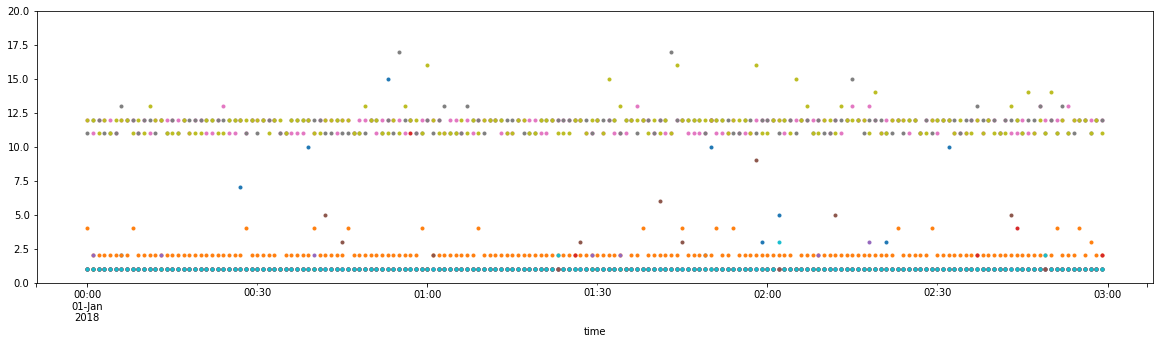

In [9]:
from matplotlib import pyplot as plt
ax = df.plot(style=".",figsize=(20,5),legend=False, ylim=(0,20), linewidth=0.2)

We can also summarize the individual distributions as box plots:

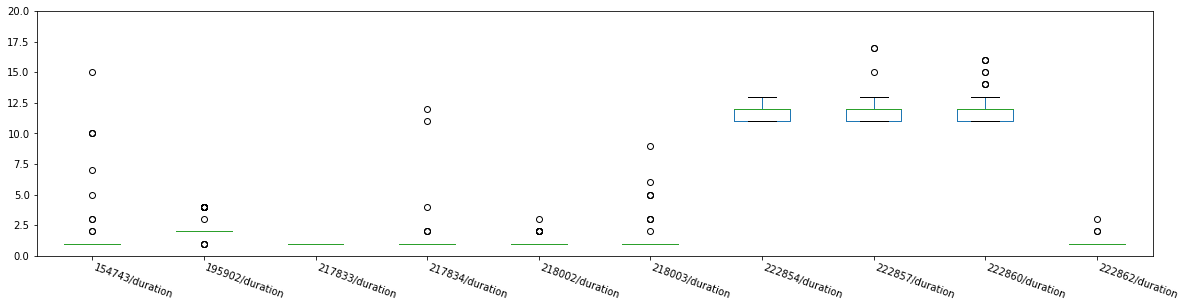

In [10]:
ax = df.plot(figsize=(20,5),legend=False, ylim=(0,20), kind="box")
ax.figure.autofmt_xdate(rotation=-20,ha="left")

### Working with Histogram Data

Histogram data can be fetched using the kind="histogram" parameter to fetch.
Numeric metrics will be converted to histograms.
Histograms are represented as libcircllhist objects, which have very efficient methods for the most common histogram operations (mean, quantiles).

In [11]:
MH = circ.search("api`GET`/getState", limit=1)
print(MH)

check_id   type       metric_name
--------------------------------------------------
160764     histogram  api`GET`/getState                                 


Let's fetch the 1h latency distributions of this API for the timespan of one day.

In [12]:
RH = MH.fetch(datetime(2018,1,1), 60*60, 24, kind="histogram")

We can plot the resulting histograms with a little helper function.

In [13]:
### SKIP THIS CELL ###

def circllhist_plot(H,**kwargs):
    x=[] # midpoints
    h=[] # height
    w=[] # widths
    for b, c in H:
        x.append(b.midpoint())
        h.append(c / b.width())
        w.append(b.width())
    return plt.bar(x,h,w,**kwargs,)

(0, 100)

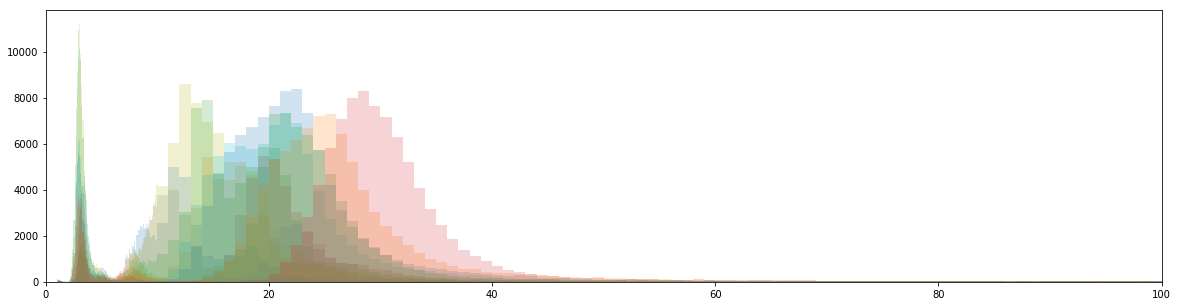

In [14]:
fig = plt.figure(figsize=(20, 5))
for H in RH['160764/api`GET`/getState']:
    circllhist_plot(H, alpha=0.2)
ax = fig.get_axes()
ax[0].set_xlim(0,100)

Again we can directly import the data into a pandas data frame, and perform some calculations on the data:

In [15]:
dfh = pd.DataFrame(RH)

# [OPTIONAL] Make the DataFrame aware of the time column
dfh['time']=pd.to_datetime(dfh['time'],unit='s')
dfh.set_index('time', inplace=True)

In [16]:
dfh['p99'] = dfh.iloc[:,0].map(lambda h: h.quantile(0.99))
dfh['p90'] = dfh.iloc[:,0].map(lambda h: h.quantile(0.99))
dfh['p95'] = dfh.iloc[:,0].map(lambda h: h.quantile(0.99))
dfh['p50'] = dfh.iloc[:,0].map(lambda h: h.quantile(0.5))
dfh['mean'] = dfh.iloc[:,0].map(lambda h: h.mean())
dfh.head()

,160764/api`GET`/getState,p99,p90,p95,p50,mean
time,,,,,,
2018-01-01 00:00:00,"{""+29e-002"": 2, ""+40e-002"": 6, ""+50e-002"": 8, ...",112.835714,112.835714,112.835714,11.992790,15.387013
2018-01-01 01:00:00,"{""+40e-002"": 2, ""+50e-002"": 2, ""+59e-002"": 5, ...",114.961628,114.961628,114.961628,16.567822,19.542284
2018-01-01 02:00:00,"{""+40e-002"": 3, ""+50e-002"": 12, ""+59e-002"": 4,...",118.124324,118.124324,118.124324,20.556859,24.012226
2018-01-01 03:00:00,"{""+29e-002"": 1, ""+40e-002"": 7, ""+50e-002"": 21,...",427.122222,427.122222,427.122222,20.827982,37.040173
2018-01-01 04:00:00,"{""+40e-002"": 6, ""+50e-002"": 26, ""+59e-002"": 15...",496.077778,496.077778,496.077778,23.247373,40.965517


## The CAQL API

Circonus comes with a wide range of data analysis capabilities that are integrated into the Circonus Analytics Query Language [CAQL](https://login.circonus.com/resources/docs/user/caql_reference.html).

CAQL provides highly efficient data fetching operations that allow you to process multiple metrics at the same time.
Also by performing the computation close to the data, you can safe time and bandwithd.

To get started we search for `duration` metrics, like we did before, using CAQL:

In [17]:
A = circ.caql('search:metric("duration")', datetime(2018,1,1), 60, 5000)
dfc = pd.DataFrame(A)
dfc.head()

,output[0],output[10],output[11],output[12],output[13],output[14],output[15],output[16],output[17],output[18],...,output[21],output[2],output[3],output[4],output[5],output[6],output[7],output[8],output[9],time
0,4,12,1,1,2,1,1,1,11,1,...,1,1,1,1,1,1,11,12,1,1514764800
1,2,12,1,1,1,1,1,1,11,1,...,1,1,1,1,1,2,12,11,1,1514764860
2,2,11,1,1,2,1,1,1,12,1,...,1,1,1,1,1,1,12,12,1,1514764920
3,2,12,1,1,2,1,1,1,12,1,...,1,1,1,1,1,1,11,12,1,1514764980
4,2,11,1,1,2,1,1,1,11,1,...,1,1,1,1,1,1,11,12,1,1514765040


This API call fetched 1000 samples from 22 metrics, and completed in just over 1 second.
The equivalent `circ.search().fetch()` statment would have taken around one minute to complete.

One drawback of the CAQL fetching is, that we use the metric names in the output.
We are working on resolving this shortcoming.

To showcase some of the analytics features we compute a rolling mean over the second largest duration metric in the above cluster using CAQL,
and plot the transfomed data using pandas.

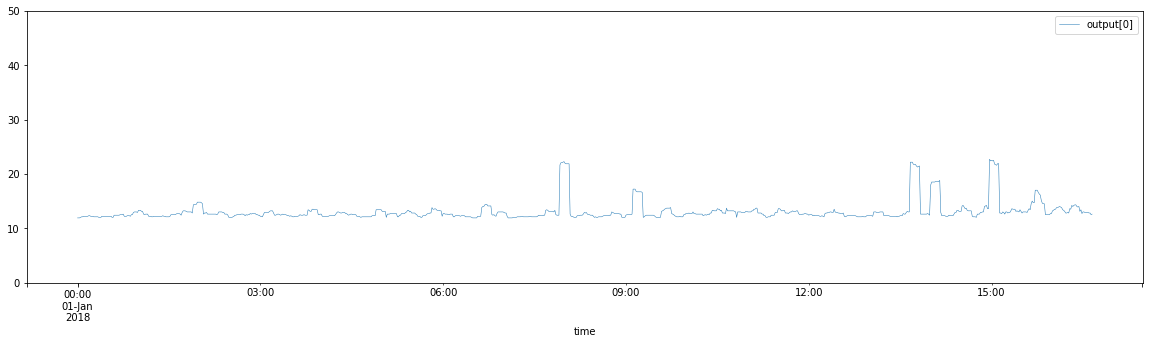

In [18]:
B = circ.caql("""

search:metric("duration") | stats:trim(1) | stats:max() | rolling:mean(10M)

""", datetime(2018,1,1), 60, 1000)
df = pd.DataFrame(B)
df['time']=pd.to_datetime(df['time'],unit='s')
df.set_index('time', inplace=True)
df.plot(figsize=(20,5), lw=.5,ylim=(0,50))

You can also fetch histogram data with `circ.caql()`:

In [19]:
AH = circ.caql('search:metric:histogram("api`GET`/getState")', datetime(2018,1,1), 60*60, 24)
dfch = pd.DataFrame(AH)
dfch.head()

,output[0],time
0,"{""+29e-002"": 2, ""+40e-002"": 6, ""+50e-002"": 8, ...",1514764800
1,"{""+40e-002"": 2, ""+50e-002"": 2, ""+59e-002"": 5, ...",1514768400
2,"{""+40e-002"": 3, ""+50e-002"": 12, ""+59e-002"": 4,...",1514772000
3,"{""+29e-002"": 1, ""+40e-002"": 7, ""+50e-002"": 21,...",1514775600
4,"{""+40e-002"": 6, ""+50e-002"": 26, ""+59e-002"": 15...",1514779200


We can perform a wide variety of data transformation tasks directly inside Circonus using CAQL expressions.
This speeds up the computation even further.
Another advantage is, that we can leverage CAQL queries for live graphing and alerting in the Circonus UI.

In this example we compute how many requests were serviced above certain latencty thresholds.

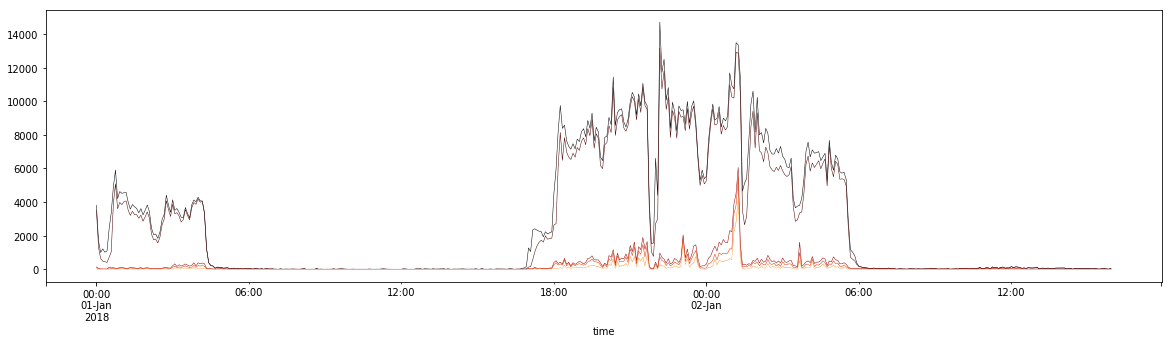

In [20]:
B = circ.caql('''

search:metric:histogram("api`GET`/getState") | histogram:count_above(0,10,50,100,500,1000)

''', datetime(2018,1,1), 60*5, 24*20)
dfc2 = pd.DataFrame(B)
dfc2['time']=pd.to_datetime(dfc2['time'],unit='s')
dfc2.set_index('time', inplace=True)
dfc2.plot(figsize=(20,5), colormap="gist_heat",legend=False, lw=.5)

## Conclusion

Getting Circonus-data into python has never been easier.
We hope that this blog post allows you to get started with the new data fetching capabilities.
If you run into any problems or have some suggestions, feel free to open an issue on [GitHub](github.com/circonus-labs/python-circonusapi),
or get in touch on our [Slack channel](http://slack.s.circonus.com/).
